**Updates Nov 10th, 2018**
* OpenSlide can now be installed in Colab.
* A folder containing example slides and tumor masks is linked below. These should be sufficient for your project. The goal is to build a working end-to-end prototype, not to match the accuracy from the papers (or to train on a giant amount of data).


---


Below is an example program that shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. 

* To run this code, first you will need to install [OpenSlide](https://openslide.org/), the only non-Python dependency. 

* You can find a folder of slides and tumor masks [here](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing). There are 22 slides and tissue masks. The tissue masks were produced using [ASAP](https://github.com/computationalpathologygroup/ASAP) and the instructions on the competition website. I did this in advance for you, so you wouldn't have to spend energy installing ASAP (it has a variety of dependencies, depending on your OS). This way, you'll only need to install OpenSlide.

* This amount of data should be more than sufficient for our project. (If you'd like to work with more, you will need to produce tissue masks yourself using ASAP). 


* OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom) you can use to view the tissue images (after installing open slide, clone that repo, `cd` into the examples, and run `python deepzoom_server.py`. You will need install open slide on your computer, and run this notebook locally for that to work.







In [0]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [0]:
# Download an example slide and tumor mask
# Note: these are hosted on Google Cloud Storage.
# The remainder are in a Google Drive folder, linked above.

slide_path = 'tumor_091.tif'
tumor_mask_path = 'tumor_091_mask.tif'

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

In [0]:
#https://drive.google.com/open?id=18PgD-HCoca5Fp-7l7NdhQ1NEK2P35q0u

In [0]:
# slide_path = 'tumor_002.tif'
# tumor_mask_path = 'tumor_001_mask.tif'

# #slide_url = 'https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing/%s' % slide_path
# slide_url = 'https://drive.google.com/file/d/18PgD-HCoca5Fp-7l7NdhQ1NEK2P35q0u/view?usp=sharing'
# mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# # Download the whole slide image
# #if not os.path.exists(slide_path):
# !curl -O $slide_url

# # Download the tumor mask
# if not os.path.exists(tumor_mask_path):
#   !curl -O $mask_url

In [0]:
#slide_url

In [0]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

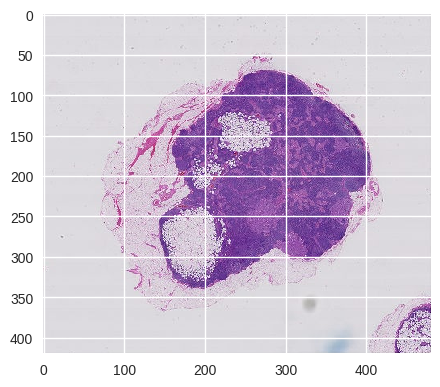

In [97]:
# Example: read the entire slide at level 5

# High zoom levels may not fit into memory.
# That's why we use OpenSlide. You can use the below function
# to extract regions from high zoom levels without having to 
# read the entire image.

# Note: this is just for demo purposes. 

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to see if same region on the mask image contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=7, 
                         width=slide.level_dimensions[7][0], 
                         height=slide.level_dimensions[7][1])

plt.figure(figsize=(5,5), dpi=100)
plt.imshow(slide_image)

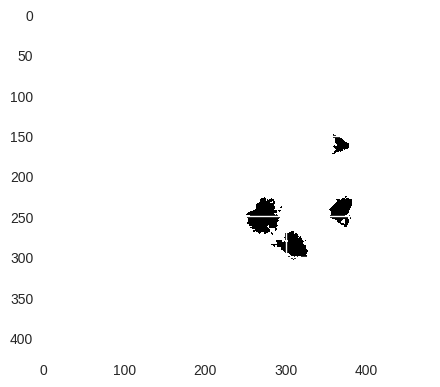

In [98]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=7, 
                        width=slide.level_dimensions[7][0], 
                        height=slide.level_dimensions[7][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(5,5), dpi=100)
plt.imshow(mask_image)

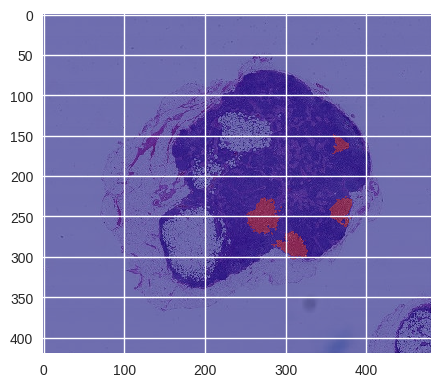

In [99]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.

plt.figure(figsize=(5,5), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

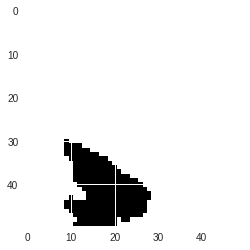

In [0]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
#region = read_slide(tumor_mask, x=400 * 128, y=450 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(region)

In [0]:
np.mean(region)

0.096

In [72]:
#Level 7 dimension: 480 x 420
from skimage.transform import resize
import math

step = 4
window = 50
width_lim = math.ceil((slide.level_dimensions[7][0] - window)/step)
height_lim = math.ceil((slide.level_dimensions[7][1] - window)/step)
#width = slide.level_dimensions[7][0] - step_size +1
#height = slide.level_dimensions[7][1] - step_size +1
print(width_lim, height_lim)
#fig,ax = plt.subplots(height_lim, width_lim, figsize = (3,3))
x = np.empty(shape=(width_lim, height_lim, window, window,3))
y = np.empty(shape = (width_lim, height_lim))
print(x.shape, y.shape)
for i in range(width_lim):
  for j in range(height_lim):
    slide_region = read_slide(slide, x= i * step * 128, 
                                     y= j * step * 128, 
                                     level=7, width= window, height=window)#[:,:,0]
    #slide_region = resize(slide_region,(192,192))  
    tumor_region = read_slide(tumor_mask, x= i * step * 128, 
                                     y= j * step * 128, 
                                     level=7, width= window, height=window)[:,:,0]
    x[i][j] = slide_region
    y[i][j] = math.ceil(np.mean(tumor_region))
#     ax[j][i].imshow(slide_region)
#     ax[j][i].imshow(tumor_region, cmap='jet', alpha=0.5)
#     ax[j][i].set_xticks([])
#     ax[j][i].set_yticks([])

108 93
(108, 93, 50, 50, 3) (108, 93)


In [73]:
x_flat = x.reshape(108*93,50,50,3)
#x_flat = np.reshape(x_flat, (x_flat.shape[0], -1))
y_flat = y.reshape(108*93) 
print(x_flat.shape)
print(y_flat.shape)

(10044, 50, 50, 3)
(10044,)


In [75]:
y_flat.sum()/len(y_flat)

0.14187574671445638

In [0]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_flat, y_flat, stratify = y_flat, test_size = 0.2)

In [0]:
# import tensorflow as tf
# xception = tf.keras.applications.Xception(weights = 'imagenet',input_shape=(192, 192, 3), include_top=False)
# xception.trainable=False

83689472/83683744 [==============================] - 8s 0us/step


In [36]:
import tensorflow as tf
vgg16 = tf.keras.applications.VGG16(weights = 'imagenet',input_shape=(50, 50, 3), include_top=False)
vgg16.trainable=False

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
# from keras import backend as K

# def recall(y_true, y_pred):
#     """Recall metric.

#     Only computes a batch-wise average of recall.

#     Computes the recall, a metric for multi-label classification of
#     how many relevant items are selected.
#     """
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall

# def precision(y_true, y_pred):
#     """Precision metric.

#     Only computes a batch-wise average of precision.

#     Computes the precision, a metric for multi-label classification of
#     how many selected items are relevant.
#     """
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision
      
# def f1(y_true, y_pred):
#     precision = precision(y_true, y_pred)
#     recall = recall(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [94]:
model = tf.keras.Sequential([
  vgg16,
  #xception,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Flatten(), 
  #tf.keras.layers.Dense(256, activation='relu'),
  #tf.keras.layers.Dropout(0.3), # Add dropout to reduce overfitting
  tf.keras.layers.Dense(128, activation = 'relu'),
  tf.keras.layers.Dense(2, activation = 'softmax')])

model.compile(optimizer=tf.train.AdamOptimizer(), 
            loss=tf.keras.losses.sparse_categorical_crossentropy,
            metrics=['accuracy'])

model_history = model.fit(x_train, y_train, epochs=5,  
                          validation_split=0.1,
                          verbose = 2)

#print('Evaluation')

#evaluation = model.evaluate(ds_test, steps = math.ceil(len(x_test)/32))

#print('Test set loss: ', evaluation[0])
#print('Test set accuracy: ', evaluation[1])

#visualize(model_history)

Train on 7231 samples, validate on 804 samples
Epoch 1/5
 - 8s - loss: 0.4279 - acc: 0.9400 - val_loss: 0.2411 - val_acc: 0.9652
Epoch 2/5
 - 7s - loss: 0.1151 - acc: 0.9726 - val_loss: 0.1229 - val_acc: 0.9701
Epoch 3/5
 - 7s - loss: 0.0827 - acc: 0.9781 - val_loss: 0.1835 - val_acc: 0.9652
Epoch 4/5
 - 7s - loss: 0.0537 - acc: 0.9855 - val_loss: 0.1243 - val_acc: 0.9838
Epoch 5/5
 - 7s - loss: 0.0522 - acc: 0.9870 - val_loss: 0.1336 - val_acc: 0.9764


In [95]:
y_pred_prob = model.predict(x_test)
y_pred = y_pred_prob.argmax(1)
print(y_pred.mean())

0.16525634644101542


In [96]:
from sklearn.metrics import roc_curve,  precision_score, recall_score, f1_score
print('Test Set Evaluation\n')

evaluation = model.evaluate(x_test, y_test)

print('Loss: ', evaluation[0])
print('Accuracy: ', evaluation[1])

print('Recall: ', recall_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))

Test Set Evaluation

2009/2009 [==============================] - 2s 922us/step
Loss:  0.14561725670413608
Accuracy:  0.9656545545047287
Recall:  0.9614035087719298
F1:  0.8881685575364668
Precision:  0.8253012048192772


905504 tissue_pixels pixels (32.1 percent of the image)


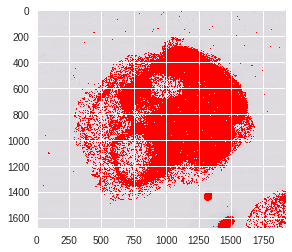

In [0]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)